In [1]:
library('hdp')
library('clusterCrit')
library('grid')
library('gridExtra')
library('ggplot2')
library('ggrepel')
library('RColorBrewer')
library('dplyr')
library('reshape2')
library('IRdisplay')
library('ggpubr')
source('../../src/tools.R')     # custom tools function
#source('../../../src/hdp_tools.R') # hdp related functions
source('../../src/hdp_tools_yanis.R')
library(scales)
theme_set(theme_minimal())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 200, # set the maximum number of rows displayed
        repr.matrix.max.cols = 200) # set the maximum number of columns displayed

Run citation('hdp') for citation instructions,
    and file.show(system.file('LICENSE', package='hdp')) for license details.

Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: magrittr


In [2]:
### Tools to get max and second max proba with corresponding components

add_first_second_predicted_component <- function(hdp_output, data) {
    # Return a dataframe giving for each patient the probability by component, as well as the assigned component and its probability (max_proba)
    # → Arguments
    #     - hdp_output: hdpSampleChain or hdpSampleMulti object
    #     - data      : original data

    # keep all DP but first (first level)
    dd_predicted <- data.frame(comp_dp_distn(hdp_output)$mean[-1,])

# change categories colnames
    colnames(dd_predicted) <- paste0('component_', 0:(ncol(dd_predicted)-1))
    components_colnames <- colnames(dd_predicted)

    # pprint various info
    print_and_flush(sprintf('Number of components: %d\n', ncol(dd_predicted) - 1))
    print_and_flush(sprintf('Number of NA rows   : %d\n', nrow(dd_predicted[rowSums(is.na(dd_predicted)) != 0,])))

    # evaluate for each row the predicted component
    dd_predicted['initial_predicted_component'] <- apply(dd_predicted, 1, function(x) { if (all(is.na(x)))
                                                                     return(NaN)
                                                                 else
                                                                     return(which.max(x)-1)
                                                                })
    dd_predicted[, 'initial_predicted_component'] <- factor(dd_predicted[, 'initial_predicted_component'])


    dd_predicted['second_predicted_component'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                     return(NaN)
                                                                 else
                                                                     tmp <- names(which.max(x[x!=max(x)]))
                                                                     return(as.numeric(substr(tmp,nchar(tmp),nchar(tmp))))
                                                                })
    dd_predicted[, 'second_predicted_component'] <- factor(dd_predicted[, 'second_predicted_component'])
    
    # evaluate for each row the maximum probability associated to the predicted component
    
    dd_predicted['max_proba'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                                  return(NaN)
                                                                              else
                                                                                 return(max(x))
                                                                            })

    dd_predicted['second_max_proba'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                                  return(NaN)
                                                                              else
                                                                                 return(max(x[x!=max(x)]))
                                                                            })

    return (dd_predicted)
}

In [3]:
### Tools to launch HDP and get results

launch <- function(data,base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab){
    number_of_chains <- chains
    chain_list <- vector('list', number_of_chains)
    hdp <- initialise_hdp_yanis(data = data,hh=base_dist,alphaa = aa,alphab= ab)


    for (i in 1:number_of_chains) {
        seed <- i * 100
        print_and_flush(sprintf('### Experiment %d (seed = %d) ###\n', i, seed))

        # run single hdp chain
        chain_list[[i]] <- activate_and_run_hdp(hdp,
                                                initcc = initial_clusters,
                                                burnin = burn,
                                                n      = posterior_samples,
                                                space  = 20,
                                                seed   = seed)
        print_and_flush('\n')
    }

    multi_output <- hdp_multi_chain(chain_list)
    print(multi_output)
}

In [4]:
df_final <- read.table("../clustering/clustering_Final_1/modif_final.tsv")

In [5]:
### Tools for distributions of HDP


num_cols = ncol(df_final)
bin <- function(x){
    set.seed(123)
  (rbinom(1, num_cols, mean(x))+1)/num_cols
}

###Normal

normal <- function(x){
    set.seed(123)
  abs(rnorm(1,mean(x),sd(x)))
}

###Poisson

poisson <- function(x){
    set.seed(123)
  (rpois(num_cols,1))/num_cols
}

###Uniform equally over all columns

equally <- function(x){
    set.seed(123)
  1/num_cols
}

###Repet 1

repet <- function(x){
    set.seed(123)
  1
}

binomial <- unlist(sapply(df_final,bin))
gaussian <- unlist(sapply(df_final,normal))
pois <- as.numeric(unlist(sapply(df_final,poisson)))
unif <- unlist(sapply(df_final,equally))
repetition <- unlist(sapply(df_final,repet))
lists<- list(binomial,gaussian,unif,repetition)


# I) Initial Component : Component 0 to 10

In [6]:
data <- df_final
posterior_samples <- 250
initial_clusters <- 17
burn <- 7000
chains <- 3
base_dist <- gaussian
aa <- 0.5
ab <-1.5

In [7]:
multi_output <- launch(data,base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab)
multi_output_cluster_10 <- extract_components(multi_output)

# get table
dd_predicted_10_components <- get_prediction_result_dataframe(multi_output_cluster_10, df_final)
tab <- get_table(dd_predicted_10_components[,'predicted_component'])
tab


#plot components
# res0 <- plot_components_size(multi_output_cluster_10,8,4.5)
# set_notebook_plot_size(22, 2.6)
# plot_comp_distn(multi_output_cluster_10,
#                 cat_names  = colnames(df_final),
#                 col        = "skyblue3",
#                 col_nonsig = "black",
#                                      )


Initialise HDP on a 2150 x 153 dataframe
  → create HDP structure... done!
  → add DP node for each patient... done!
  → assign the data to the nodes... done!
### Experiment 1 (seed = 100) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

### Experiment 2 (seed = 200) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

### Experiment 3 (seed = 300) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

Object of class hdpSampleMulti 
 Number of chains: 3 
 Total posterior samples: 750 
 Components: NO. Run hdp_extract_components 
 ----------
 Final hdpState from first chain: 
Object of class hdpState 
 Number of DP nodes: 2151 
 Index of parent DP: 0 1 1 1 1 1 1 1 1 1 ...
 Number of 

,values,count,freq
2,1,833,38.7441860465116
3,2,418,19.4418604651163
4,3,229,10.6511627906977
5,4,128,5.95348837209302
6,5,114,5.30232558139535
7,6,114,5.30232558139535
1,0,96,4.46511627906977
9,8,61,2.83720930232558
12,NaN,51,2.37209302325581
8,7,50,2.32558139534884


In [42]:
png("hdp1_CEBPA_bi.png",width=6000,height=1000,res=200)

set_notebook_plot_size(22,5)
plot_comp_distn(multi_output_cluster_10,
                cat_names  = colnames(df_final),
                col        = "skyblue3",
                col_nonsig = "black",cex.cat=0.8,comp=7
#                 plot_title = c("NPM1","TP53-complex","Additions"),cex.axis=1.5,cex.cat=1.3
#                                ,"TP53-complex","Component 4","t_8_21","inv_16","CEBPA_bi","t_11 and t_15_17","additions","inv_3")
#                                ,comp=c(1,3,9)
                                     )
dev.off()

pdf 
  2

In [64]:
png("proba1.png",width=1000,height=600,res=150)
plot_assignement_probability_by_component(dd_predicted_10_components)
dev.off()

quartz_off_screen 
                2

In [8]:
initial_components <- cbind(df_final,add_first_second_predicted_component(multi_output_cluster_10))
sum(rowSums(initial_components[initial_components$predicted_component=="NaN",1:151]))
#initial_components <- na.omit(initial_components)

Number of components: 10
Number of NA rows   : 51


[1] 0

In [11]:
#write.table(initial_components,file="initial_components_with_proba.tsv",sep='\t')
#write.table(initial_components,file="initial_components_with_proba_and_na.tsv",sep='\t')

# STEP 1: DEFINING FEATURE IN EACH COMPONENT

In [9]:
tmp <- read.table("../clustering/clustering_Final_1/initial_components_with_proba.tsv")
tmp <- read.table("../clustering/clustering_Final_1/initial_components_with_proba_and_na.tsv")
tmp$initial_refined_component <- "not_assigned"

tmp[tmp$NPM1==1,]$initial_refined_component <- "NPM1"

tmp[tmp$initial_refined_component=="not_assigned" & (tmp$TP53==1 & tmp$complex==1),]$initial_refined_component <- "TP53_complex"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==3 & (tmp$TP53==1 | tmp$complex==1),]$initial_refined_component <- "TP53_complex"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==5 & tmp$t_8_21==1,]$initial_refined_component <- "t_8_21"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==6 & tmp$inv_16==1,]$initial_refined_component <- "inv_16"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==7 & tmp$CEBPA_bi==1,]$initial_refined_component <- "CEBPA_bi"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==8 & (tmp$t_v_11==1 | tmp$t_9_11==1),]$initial_refined_component <- "t_11"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==8 & tmp$t_15_17==1,]$initial_refined_component <- "t_15_17"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==9 & (tmp$add_8==1 | tmp$add_13==1 | tmp$add_21==1 | tmp$add_22==1),]$initial_refined_component <- "additions"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==10 & tmp$inv_3==1,]$initial_refined_component <- "inv_3"

tmp[is.na(tmp$max_proba),]$initial_refined_component <- "no_events"

In [10]:
table(tmp$initial_refined_component)


   additions     CEBPA_bi       inv_16        inv_3    no_events not_assigned 
          21           35           85           13           51          915 
        NPM1         t_11      t_15_17       t_8_21 TP53_complex 
         682           31           19           99          199 

In [11]:
# Patients that did not pass the first test (not defining feature of their component)
table(tmp[tmp$initial_refined_component=="not_assigned" & !is.element(tmp$initial_predicted_component,c(0,2,4)),]$initial_predicted_component)
cat("Number of patients for second max proba in HDP 1: ", sum(table(tmp[tmp$initial_refined_component=="not_assigned" & !is.element(tmp$initial_predicted_component,c(0,2,4)),]$initial_predicted_component)))


  1   3   5   6   7   8   9  10 
160  32  14  29  14  11   5  16 

Number of patients for second max proba in HDP 1:  281

# STEP 2: SECOND MAX PROBA WITH DEFINING FEATURES

In [12]:
### Get Min Proba for each component
min_proba_NPM1 = min(tmp[tmp$initial_predicted_component==1,]$max_proba,na.rm=T)

min_proba_TP53_complex = min(tmp[tmp$initial_predicted_component==3,]$max_proba,na.rm=T)

min_proba_t_8_21 = min(tmp[tmp$initial_predicted_component==5,]$max_proba,na.rm=T)

min_proba_inv_16 = min(tmp[tmp$initial_predicted_component==6,]$max_proba,na.rm=T)

min_proba_CEBPA_bi = min(tmp[tmp$initial_predicted_component==7,]$max_proba,na.rm=T)

min_proba_transloc = min(tmp[tmp$initial_predicted_component==8,]$max_proba,na.rm=T)

min_proba_additions = min(tmp[tmp$initial_predicted_component==9,]$max_proba,na.rm=T)

min_proba_inv_3 = min(tmp[tmp$initial_predicted_component==10,]$max_proba,na.rm=T)

In [13]:
## Refine patients with second max proba.

tmp[tmp$initial_refined_component=="not_assigned"  ,]$initial_refined_component  <- apply(tmp[tmp$initial_refined_component=="not_assigned" ,], 1,function(x) {
        if (all(is.na(x['second_predicted_component'])))
            return(NaN)
        else 
            return(ifelse(x['second_predicted_component']==3 & x['second_max_proba']>=0.75*min_proba_TP53_complex & (x['complex']==1 | x["TP53"]==1),"TP53_complex",
                          
                   ifelse(x['second_predicted_component']==5 & x['second_max_proba']>=0.75*min_proba_t_8_21 & x['t_8_21']==1 ,"t_8_21",
                          
                   ifelse(x['second_predicted_component']==6 & x['second_max_proba']>=0.75*min_proba_inv_16 & x['inv_16']==1,"inv_16", 
                          
                   ifelse(x['second_predicted_component']==7  & x['second_max_proba']>=0.75*min_proba_CEBPA_bi & x['CEBPA_bi']==1,"CEBPA_bi", 
                          
                   ifelse(x['second_predicted_component']==8 & x['second_max_proba']>=0.75*min_proba_transloc & (x['t_v_11']==1 | x['t_9_11']==1),"t_11",
                   ifelse(x['second_predicted_component']==8 & x['second_max_proba']>=0.75*min_proba_transloc & x['t_15_17']==1 ,"t_15_17",
                          
                   ifelse(x['second_predicted_component']==9 & x['second_max_proba']>=0.75*min_proba_additions & (x['add_8']==1 | x['add_13']==1 | x['add_21']==1 | x['add_22']==1 ),"additions",
                          
                   ifelse(x['second_predicted_component']==10 & x['second_max_proba']>=0.75*min_proba_inv_3 & x['inv_3']==1,"inv_3",       
                   "not_assigned")))))))))
    })
table(tmp$initial_refined_component)


   additions     CEBPA_bi       inv_16        inv_3    no_events not_assigned 
          24           39           88           13           51          888 
        NPM1         t_11      t_15_17       t_8_21 TP53_complex 
         682           41           20           99          205 

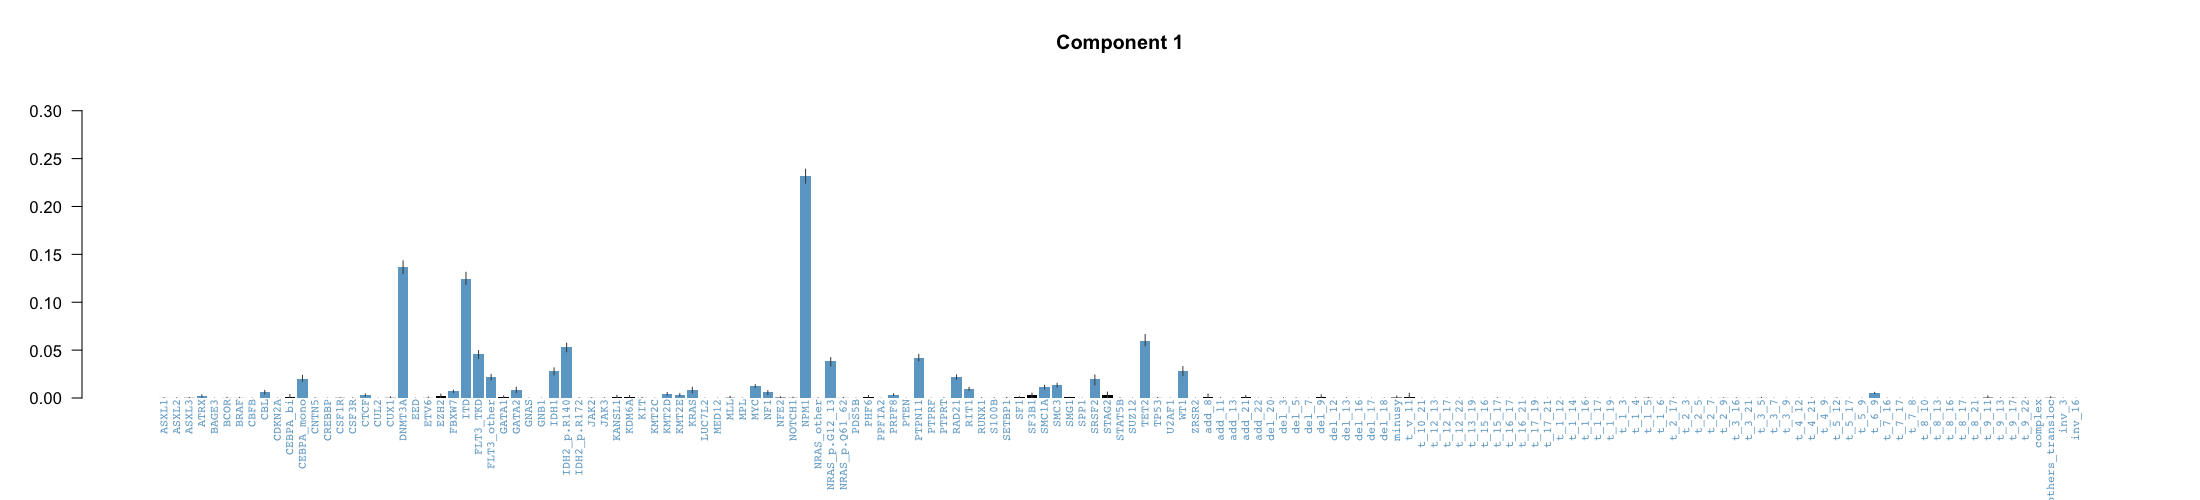

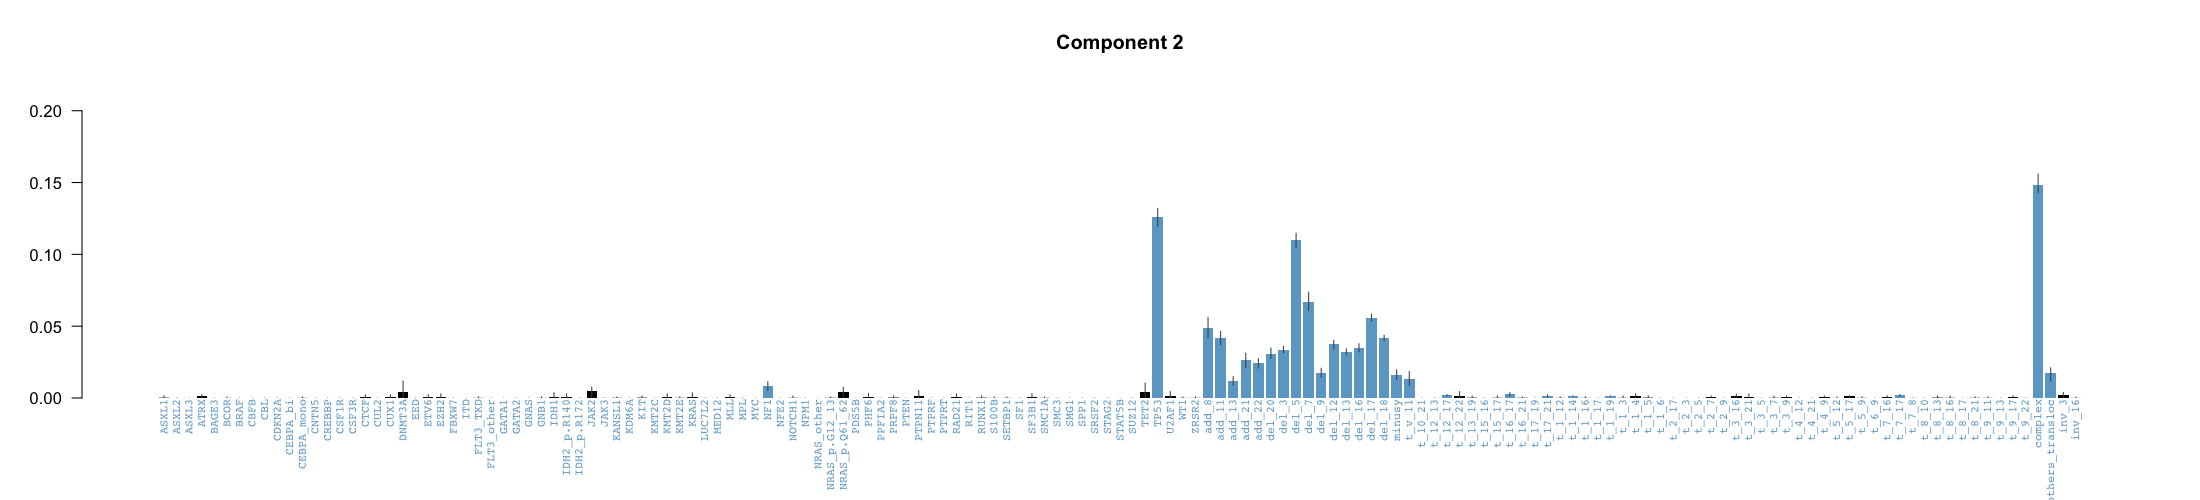

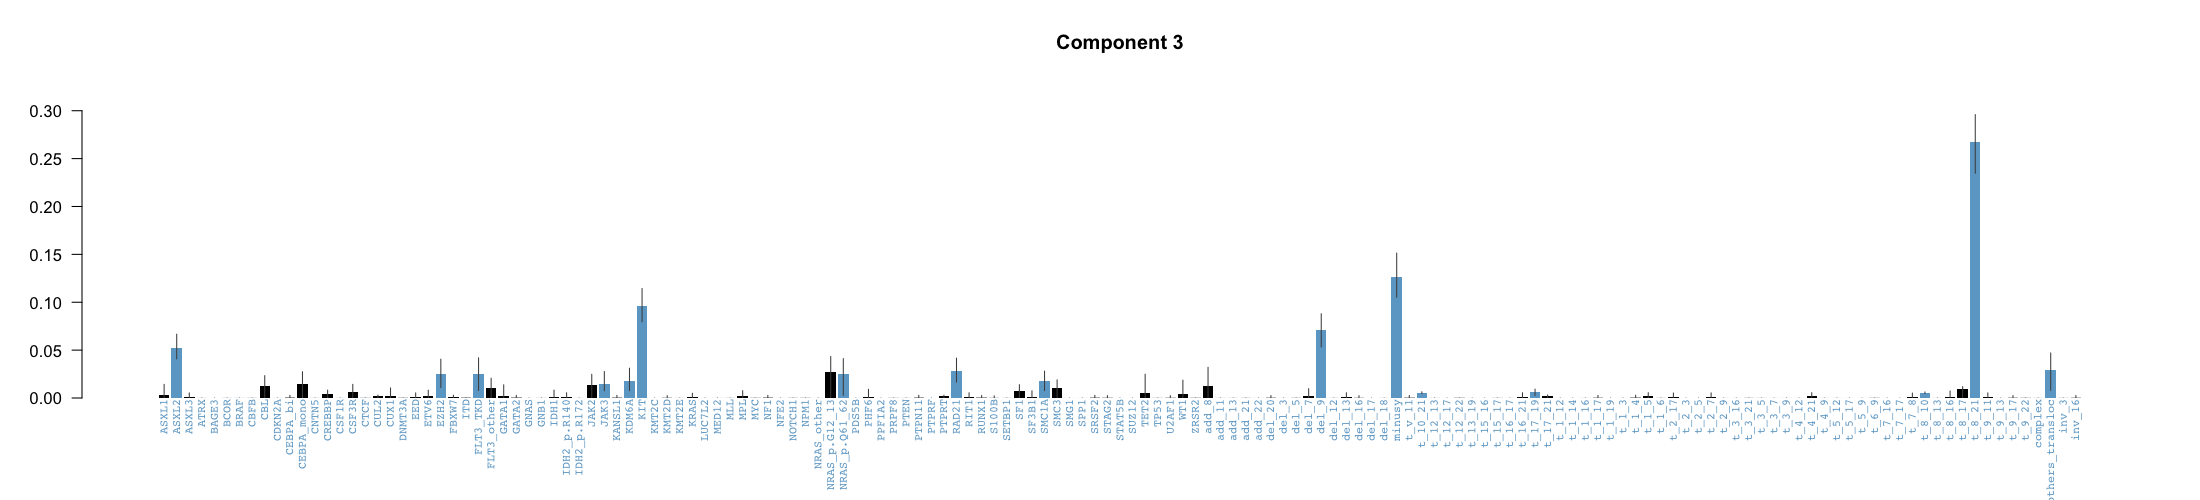

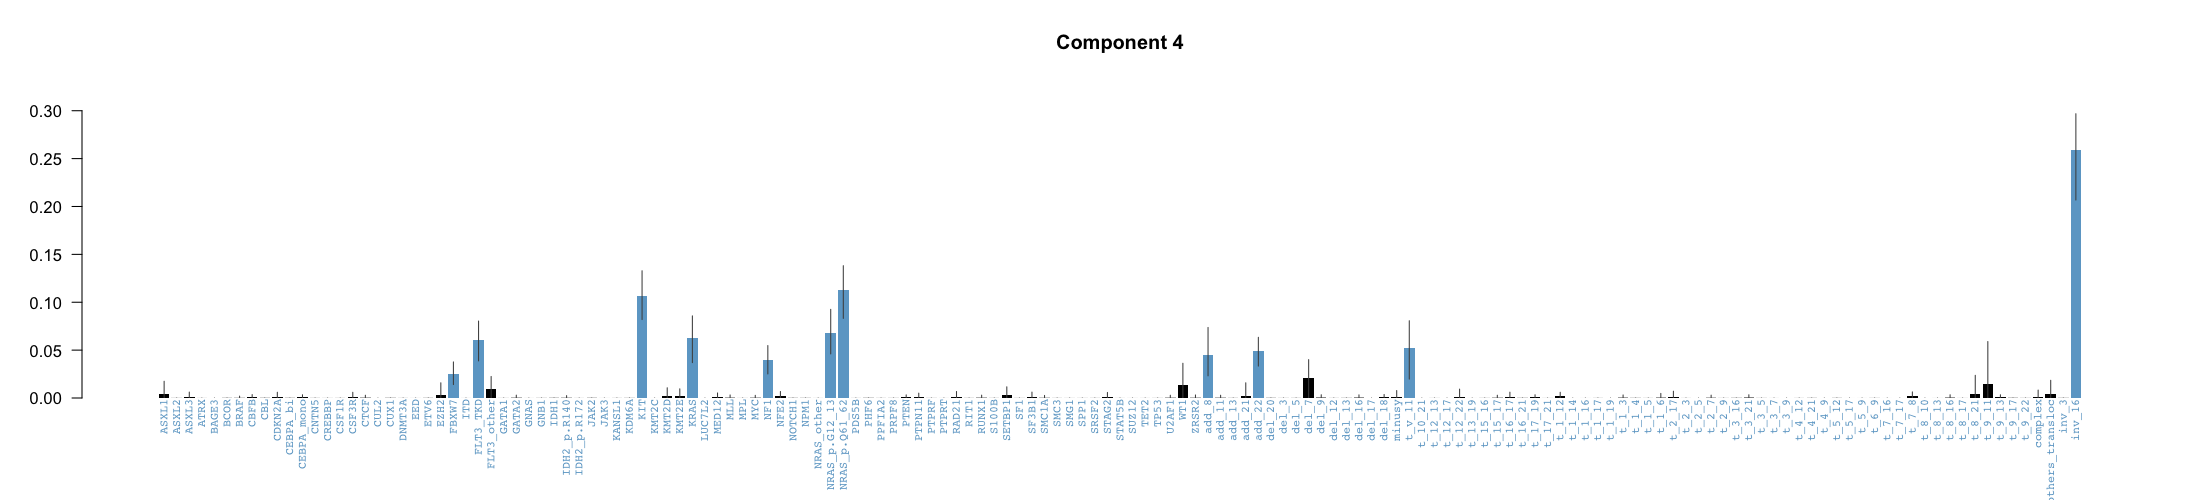

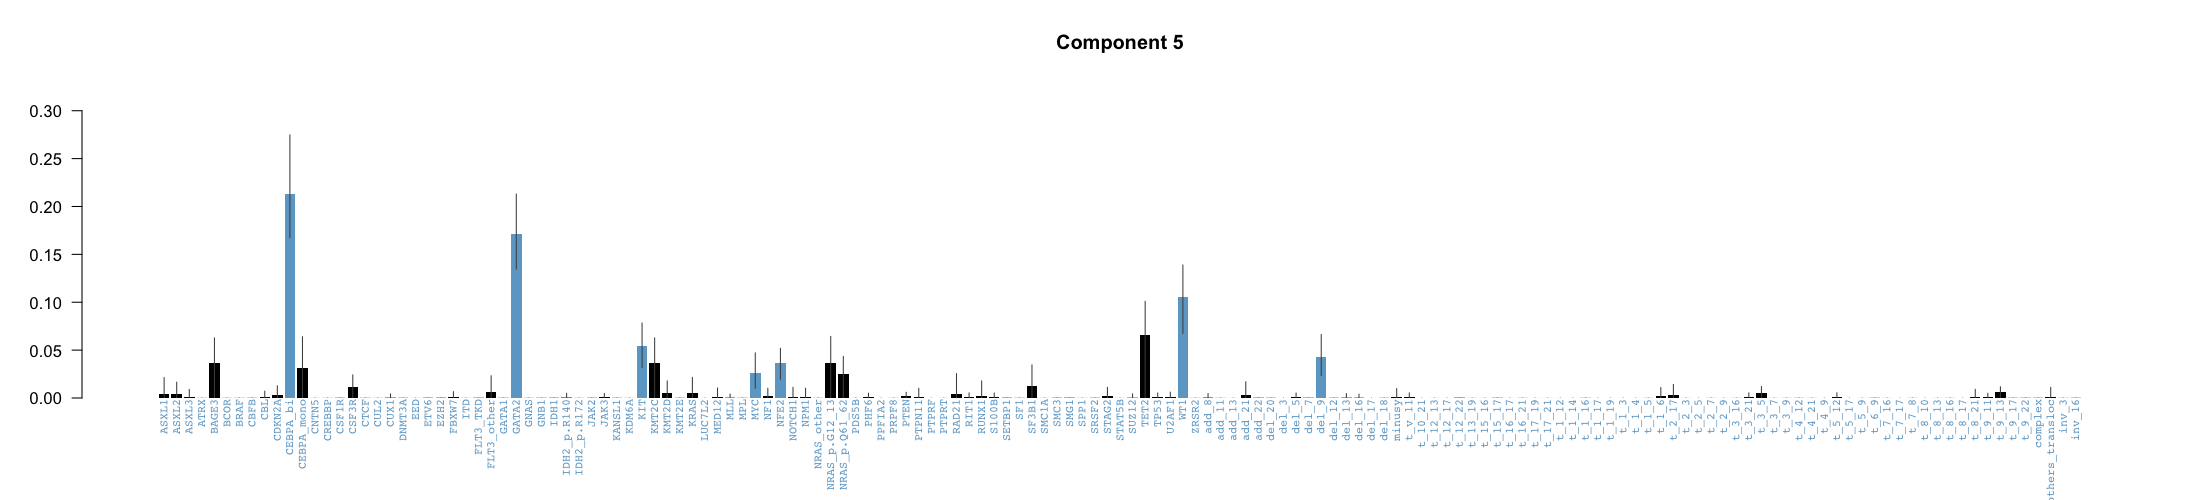

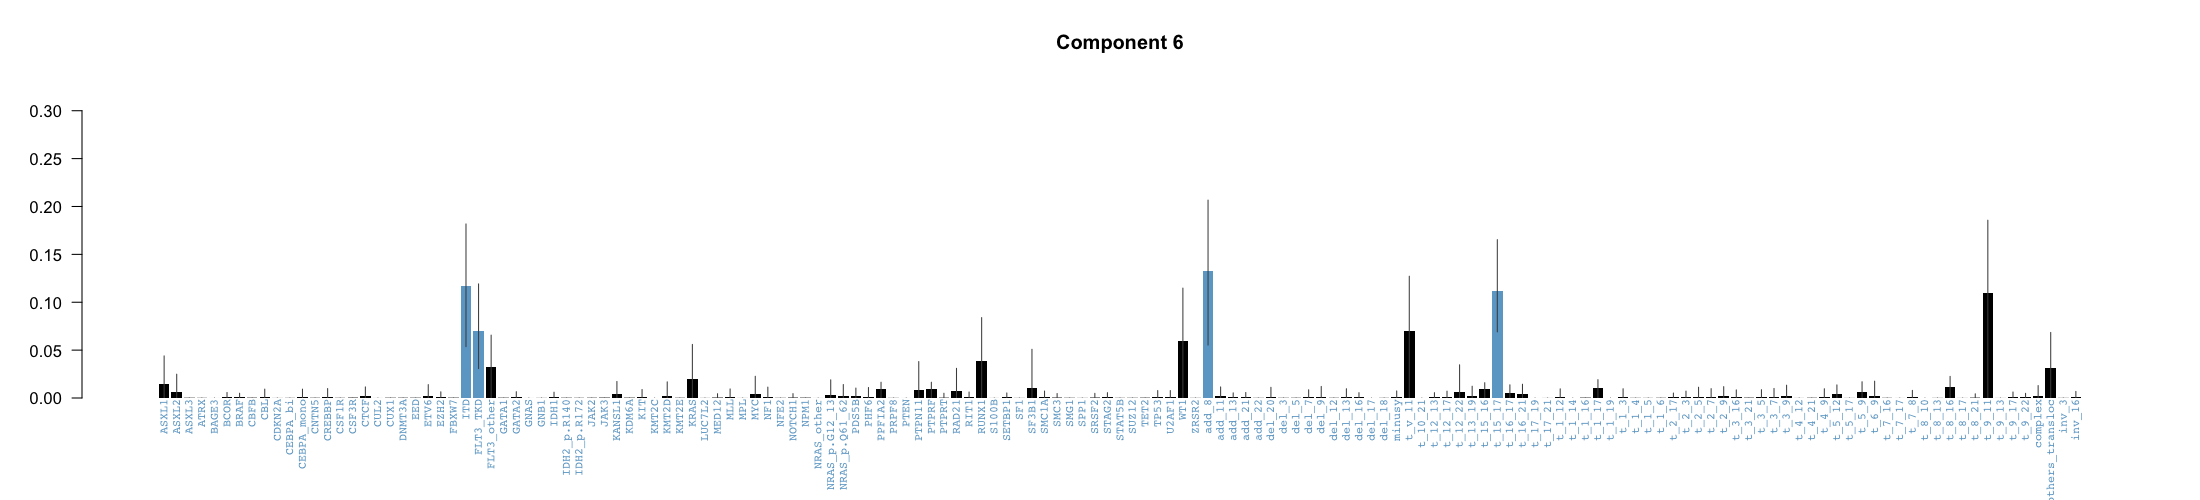

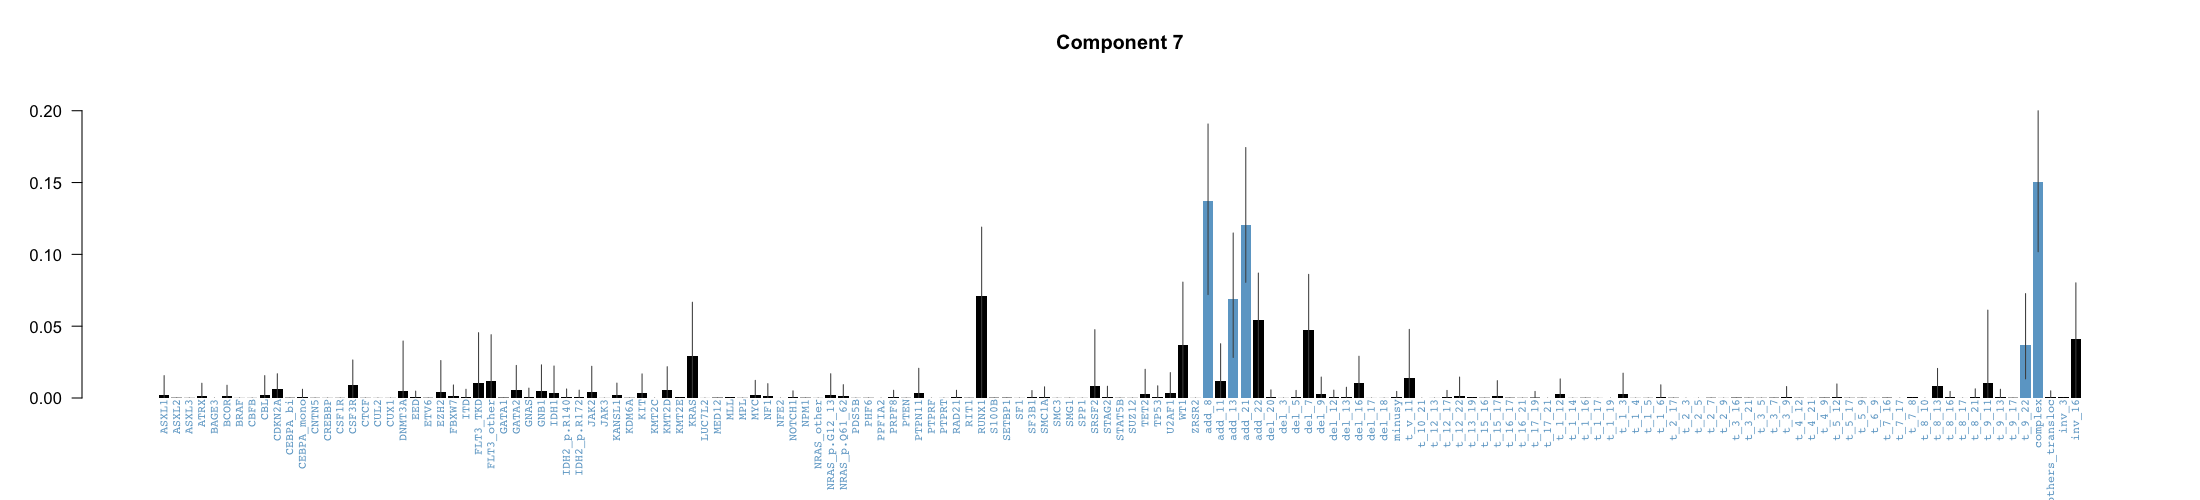

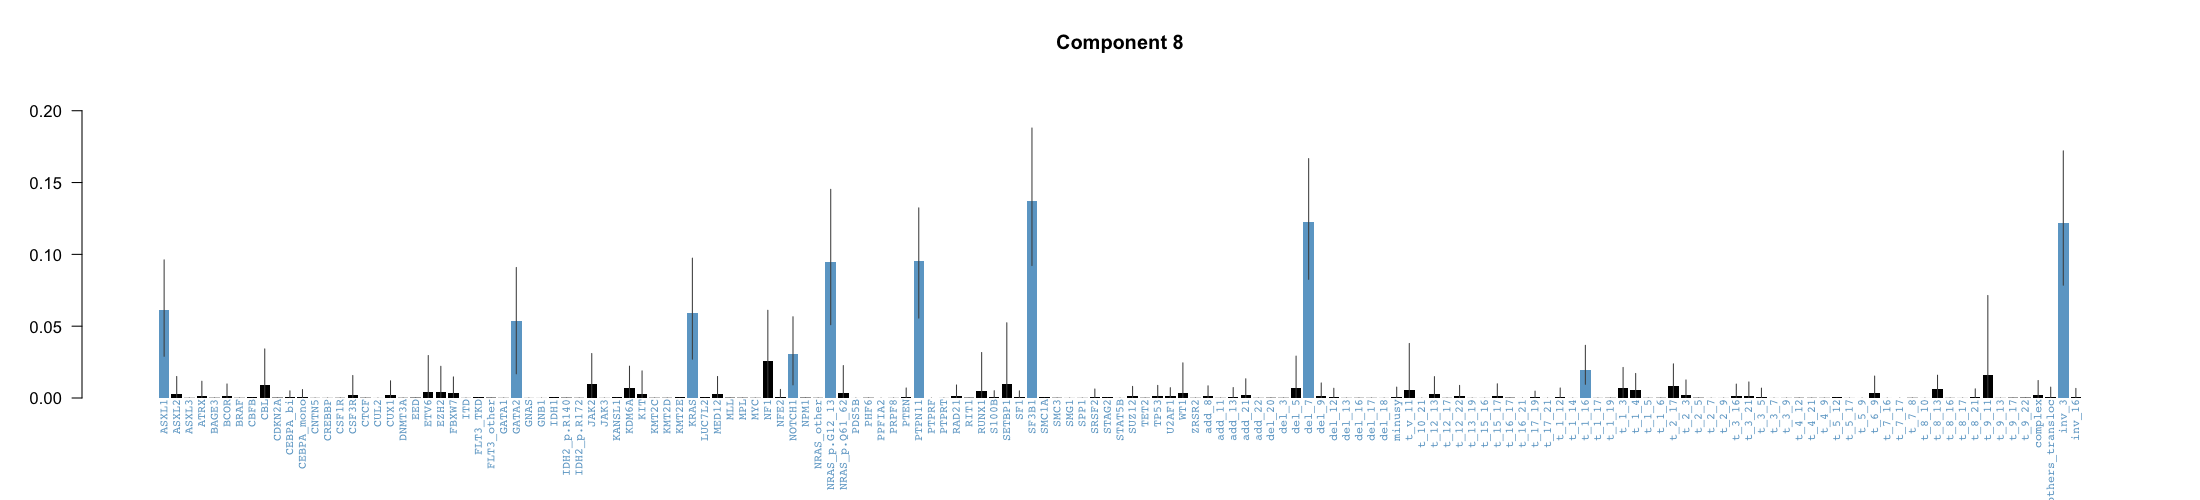

In [14]:

set_notebook_plot_size(22, 5)
    plot_comp_distn(multi_output_cluster_10,
                    cat_names  = colnames(df_final),
                    col        = "skyblue3",
                    col_nonsig = "black",
                    comp=c(1,3,5,6,7,8,9,10),
                    plot_title=c("Component 1","Component 2","Component 3","Component 4","Component 5","Component 6","Component 7","Component 8")
                                         )

# Let's reapply HDP to patients from Initial Component 0,2,4 + patients that do not have defining features from their component and that were not assigned with second max proba 

### (642 from C 0,2,4 -6 NPM1 -2 TP53-complex  =634  and 254 unassigned ) Total :888 patients

# II- HDP reapplied ON THOSE PATIENTS : 888 we just stratify by U2AF1 34 and U2AF1 157 now

In [15]:
# All dataframe with U2AF1 separation
df <- read.table("../../data/initial_dataset/1013.mut.csv",sep=',', header = T)
df <- df[df$gene=="U2AF1",c("data_pd","gene","protein")]
df$U2AF1_p.S34 <- ifelse(grepl( "34",df$protein) | grepl( "35",df$protein),1,0)
df$U2AF1_p.Q157 <- ifelse(grepl( "157",df$protein) | grepl( "156",df$protein),1,0)
df <- unique(df,by="data_pd")
newd <-  df %>% group_by(data_pd) %>% filter(n()>1)
tmp1 <- data.frame(data_pd=unique(newd$data_pd),gene=rep("U2AF1",length(unique(newd$data_pd))),protein=rep("p",length(unique(newd$data_pd))),U2AF1_p.S34=rep(0,length(unique(newd$data_pd))),U2AF1_p.Q157=rep(0,length(unique(newd$data_pd))))
for (element in unique(newd$data_pd)){    
    tmp1[tmp1$data_pd==element,]$U2AF1_p.S34 <- colSums(newd[newd$data_pd==element,"U2AF1_p.S34"])
    tmp1[tmp1$data_pd==element,]$U2AF1_p.Q157 <- colSums(newd[newd$data_pd==element,"U2AF1_p.Q157"])
}
df <- rbind(df[!is.element(df$data_pd,unique(newd$data_pd)),c("data_pd","U2AF1_p.S34","U2AF1_p.Q157","protein")],tmp1[,c("data_pd","U2AF1_p.S34","U2AF1_p.Q157","protein")])
rownames(df)<- df$data_pd
df_u2af1 <- df[,c("U2AF1_p.S34","U2AF1_p.Q157")]
tmp_u2af1 <- merge(tmp,df_u2af1,by=0,all.x=T)
rownames(tmp_u2af1) <- tmp_u2af1$Row.names
tmp_u2af1 <- tmp_u2af1[,c(2:81,170,171,83:153,169)]
tmp_u2af1[is.na(tmp_u2af1)] <- 0

In [16]:
df <- read.table("../../data/initial_dataset/1013.mut.csv",sep=',', header = T)
df <- df[df$gene=="U2AF1",c("data_pd","gene","protein")]
df$U2AF1_p.S34 <- ifelse(grepl( "34",df$protein) | grepl( "35",df$protein),1,0)
df$U2AF1_p.Q157 <- ifelse(grepl( "157",df$protein) | grepl( "156",df$protein),1,0)
df <- unique(df,by="data_pd")
newd <-  df %>% group_by(data_pd) %>% filter(n()>1)
tmp1 <- data.frame(data_pd=unique(newd$data_pd),gene=rep("U2AF1",length(unique(newd$data_pd))),protein=rep("p",length(unique(newd$data_pd))),U2AF1_p.S34=rep(0,length(unique(newd$data_pd))),U2AF1_p.Q157=rep(0,length(unique(newd$data_pd))))
for (element in unique(newd$data_pd)){    
    tmp1[tmp1$data_pd==element,]$U2AF1_p.S34 <- colSums(newd[newd$data_pd==element,"U2AF1_p.S34"])
    tmp1[tmp1$data_pd==element,]$U2AF1_p.Q157 <- colSums(newd[newd$data_pd==element,"U2AF1_p.Q157"])
}
df <- rbind(df[!is.element(df$data_pd,unique(newd$data_pd)),c("data_pd","U2AF1_p.S34","U2AF1_p.Q157","protein")],tmp1[,c("data_pd","U2AF1_p.S34","U2AF1_p.Q157","protein")])
rownames(df)<- df$data_pd
df_u2af1 <- df[,c("U2AF1_p.S34","U2AF1_p.Q157")]
tmp_u2af1 <- merge(tmp,df_u2af1,by=0,all.x=T)
rownames(tmp_u2af1) <- tmp_u2af1$Row.names
tmp_u2af1 <- tmp_u2af1[,c(2:81,171,172,83:154,170)]
tmp_u2af1[is.na(tmp_u2af1)] <- 0

In [17]:
df_to_recluster <- tmp_u2af1[tmp_u2af1$initial_refined_component=="not_assigned",]
df_to_recluster$initial_refined_component <- NULL

In [20]:
#write.table(df_to_recluster,"df_to_recluster.tsv")

In [18]:
num_cols = ncol(df_to_recluster[colSums(df_to_recluster) > 0])  ## keep only column that have at least a mutation
num_cols
bin <- function(x){
    set.seed(123)
  (rbinom(1, num_cols, mean(x))+1)/num_cols
}

###Normal

normal <- function(x){
    set.seed(123)
  abs(rnorm(1,mean(x),sd(x)))
}

###Poisson

poisson <- function(x){
    set.seed(123)
  (rpois(num_cols,1)+1)/num_cols
}

###Uniform equally over all columns

equally <- function(x){
    set.seed(123)
  1/num_cols
}

###Repet 1

repet <- function(x){
    set.seed(123)
  1
}

binomial <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],bin))
gaussian <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],normal))
pois <- as.numeric(unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],poisson)))
unif <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],equally))

[1] 129

In [19]:
data <- df_to_recluster[colSums(df_to_recluster) > 0]
posterior_samples <- 150
initial_clusters <- 5
burn <- 5000
chains <- 3
base_dist <- gaussian
aa <- 2
ab <-6
multi_output <- launch(df_to_recluster[colSums(df_to_recluster) > 0],base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab)
multi_output_recluster_5 <- extract_components(multi_output)
dd_predicted_5_components <- get_prediction_result_dataframe(multi_output_recluster_5, df_final)
tab <- get_table(dd_predicted_5_components[,'predicted_component'])
tab


Initialise HDP on a 888 x 129 dataframe
  → create HDP structure... done!
  → add DP node for each patient... done!
  → assign the data to the nodes... done!
### Experiment 1 (seed = 100) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "5000 burn-in iterations in 0.2 mins"

### Experiment 2 (seed = 200) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "5000 burn-in iterations in 0.2 mins"

### Experiment 3 (seed = 300) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "5000 burn-in iterations in 0.2 mins"

Object of class hdpSampleMulti 
 Number of chains: 3 
 Total posterior samples: 450 
 Components: NO. Run hdp_extract_components 
 ----------
 Final hdpState from first chain: 
Object of class hdpState 
 Number of DP nodes: 889 
 Index of parent DP: 0 1 1 1 1 1 1 1 1 1 ...
 Number of da

,values,count,freq
2,1,319,35.9234234234234
3,2,228,25.6756756756757
1,0,144,16.2162162162162
4,3,101,11.3738738738739
6,5,62,6.98198198198198
5,4,34,3.82882882882883
11,-- total --,888,100%


In [52]:
png("hdp2_chr_splicing.png",width=6000,height=3000,res=250)
par(mfrow=c(4,1))
set_notebook_plot_size(22,20)
plot_comp_distn(multi_output_recluster_5,
                    cat_names  = colnames(df_to_recluster[colSums(df_to_recluster) > 0]),
                    col        = "skyblue3",comp=c(1,2,3,4),
                    col_nonsig = "black",cex.cat=0.8)
dev.off()

pdf 
  2

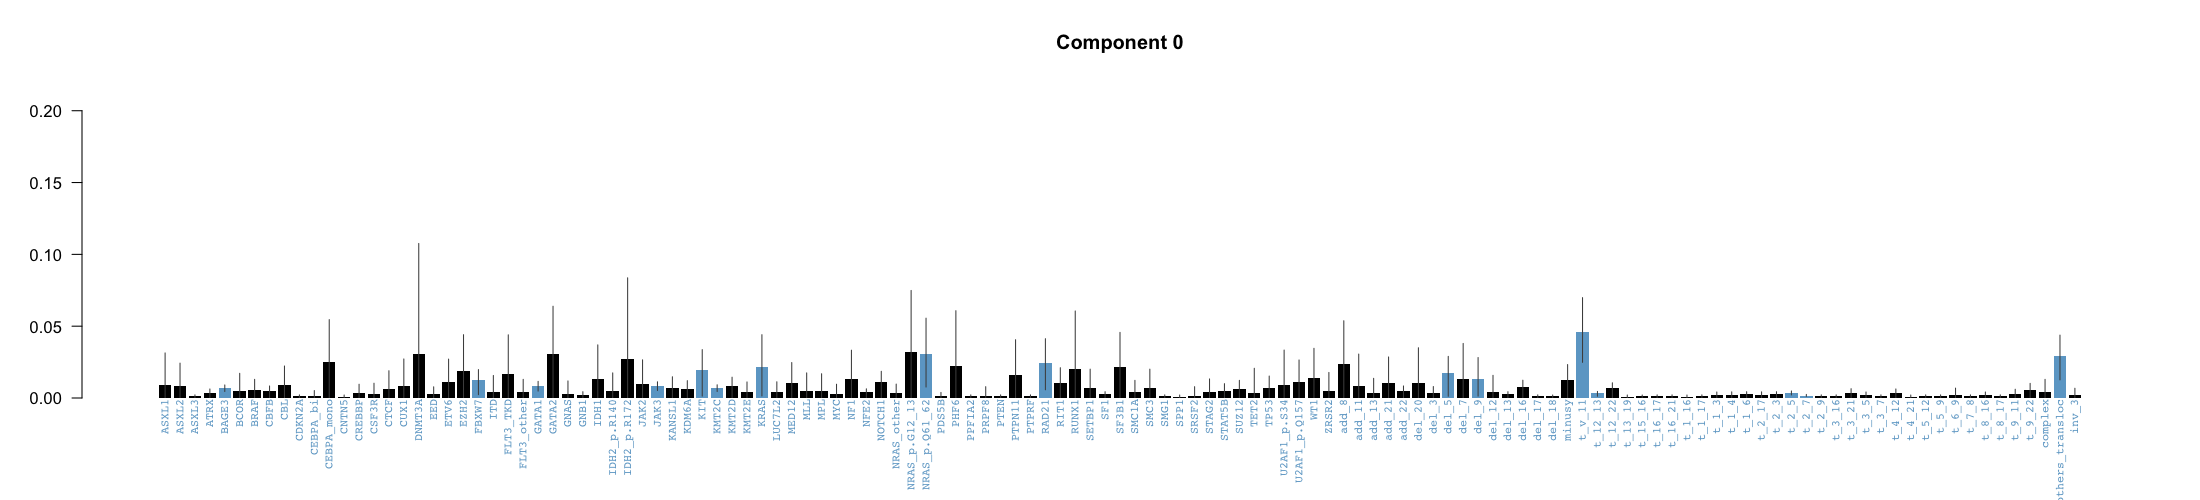

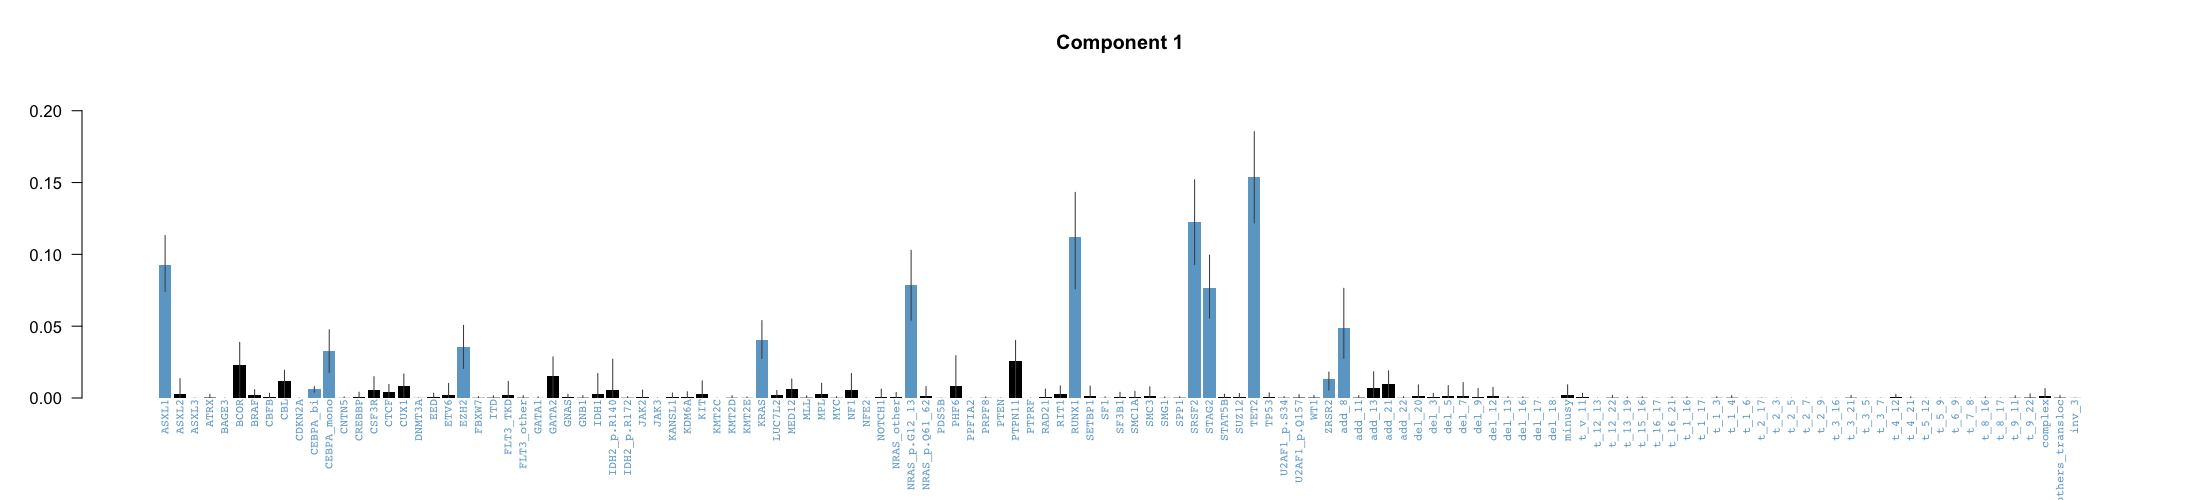

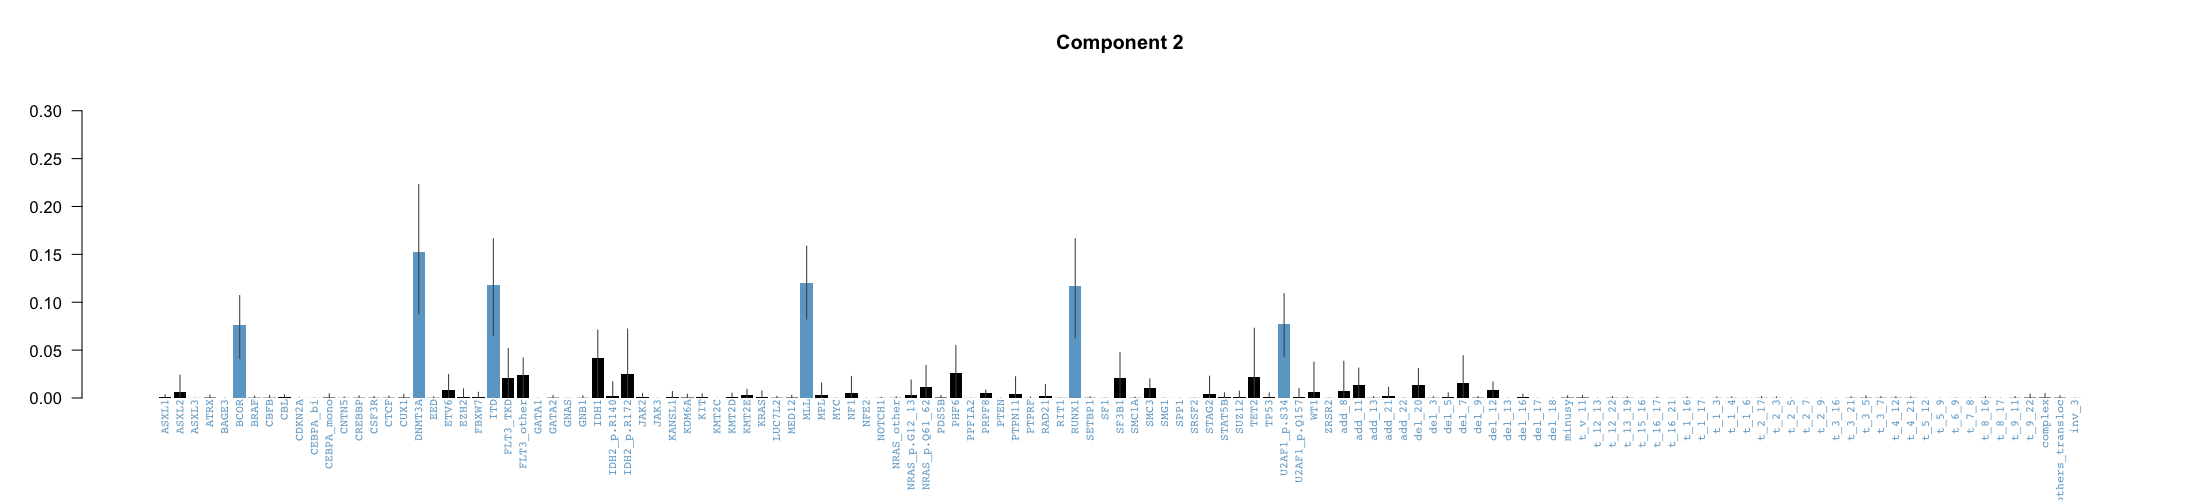

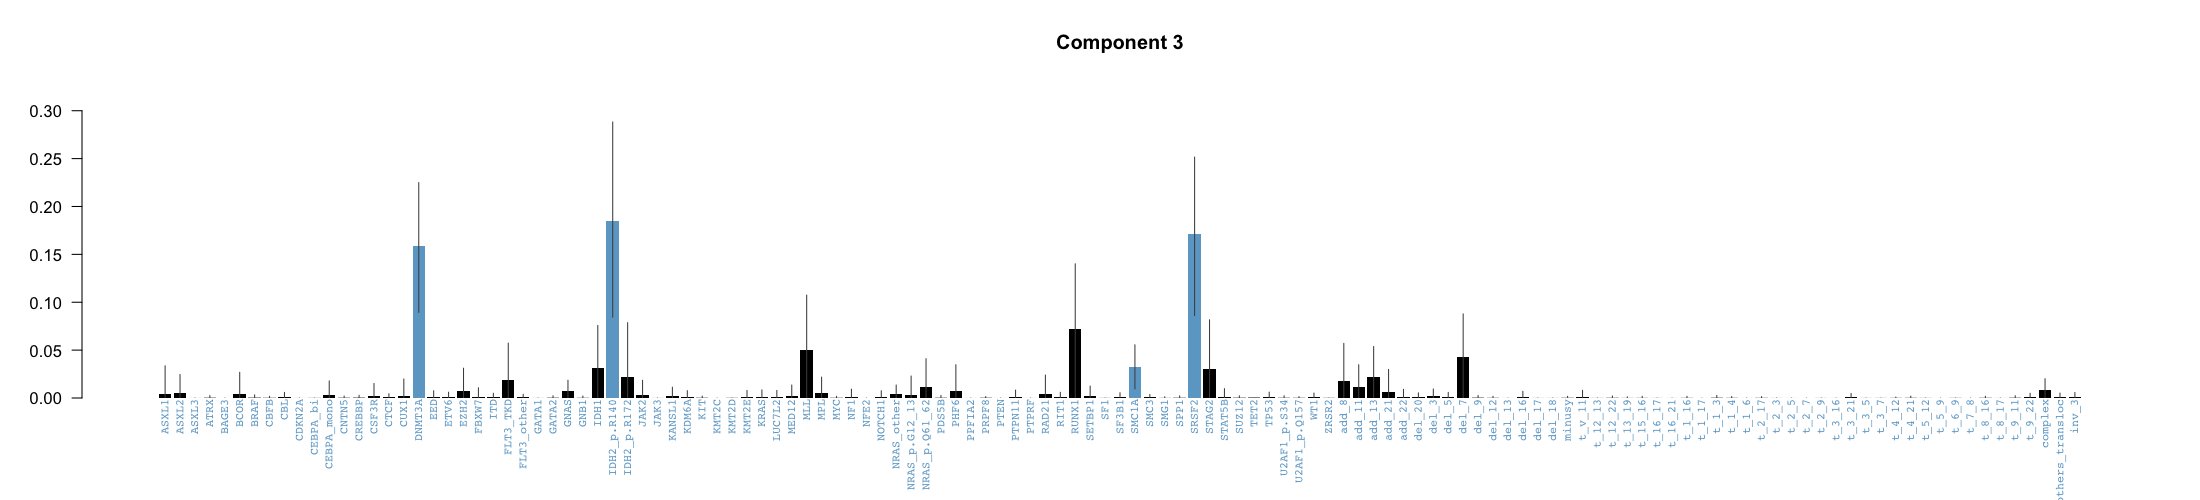

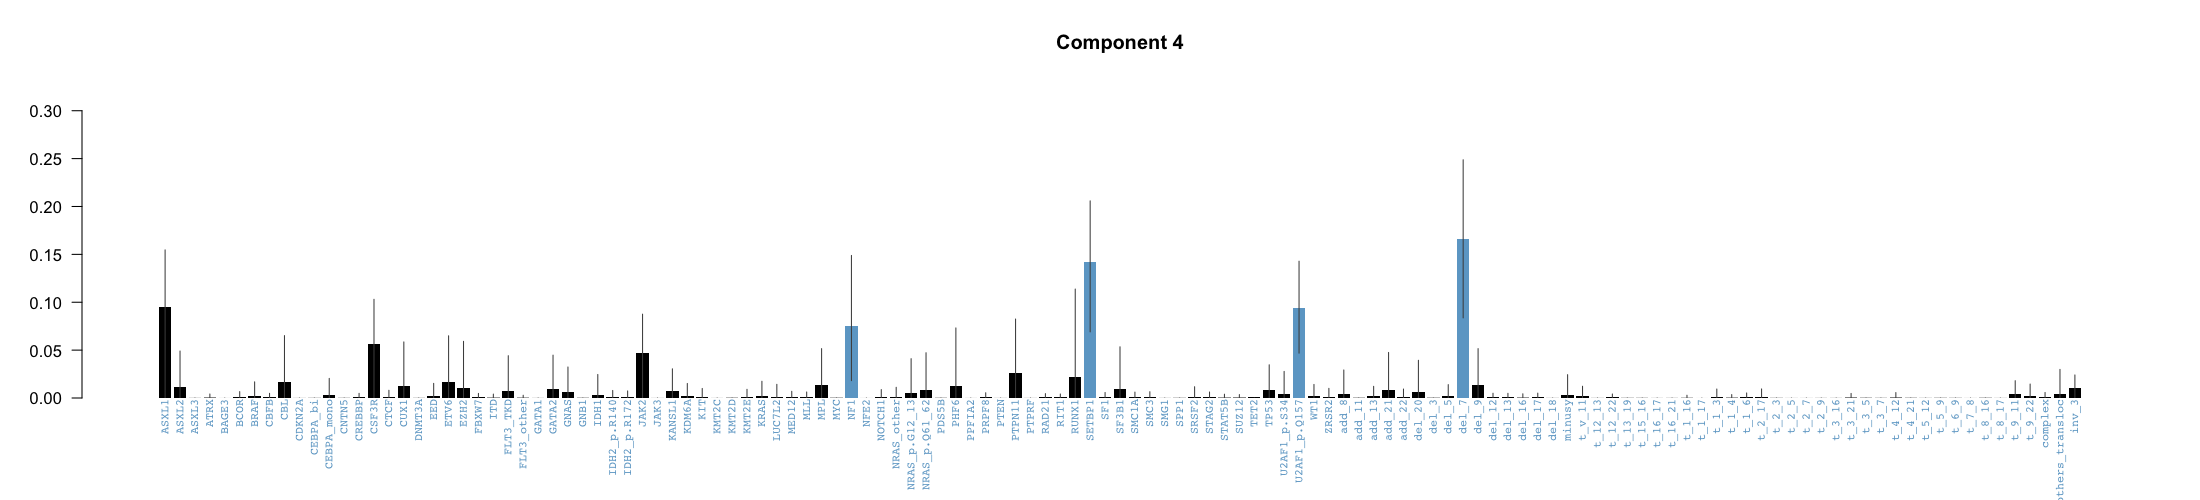

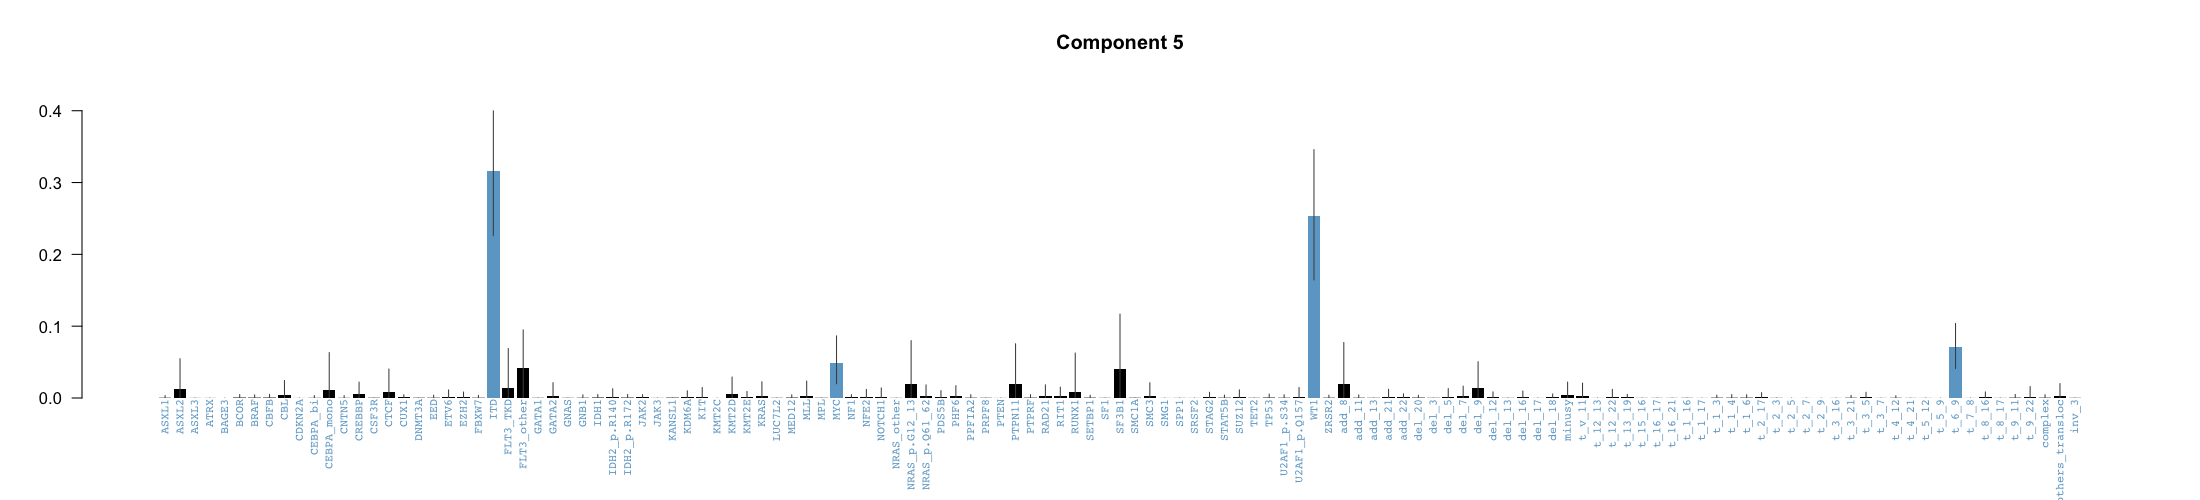

In [24]:
# png("hdp2_zoom.png",width=4000,height=2500,res=150)
# plot_components_size(multi_output_recluster_5,8,4.5)
set_notebook_plot_size(22,5)
plot_comp_distn(multi_output_recluster_5,
                    cat_names  = colnames(df_to_recluster[colSums(df_to_recluster) > 0]),
                    col        = "skyblue3",
                    col_nonsig = "black")#,#plot_title = c("Component 1 (chr splicing)","DNMT3A-IDH1-2","WT1"),cex.axis=1.5,cex.cat=1.3,comp=c(1,3,5))
# dev.off()

In [71]:
png("proba2.png",width=1000,height=600,res=150)

plot_assignement_probability_by_component(dd_predicted_5_components)

dev.off()

notch went outside hinges. Try setting notch=FALSE.


quartz_off_screen 
                2

# Refining Second HDP with defining features and second max proba

#### High second_hdp_second_max_proba for patients in component 0 so it's a good motivation for reassignment with second max proba!

In [24]:
second_hdp_probas <- add_first_second_predicted_component(multi_output_recluster_5)
colnames(second_hdp_probas) <- paste("second_hdp", colnames(second_hdp_probas), sep = "_")
data_hdp2 <- cbind(tmp_u2af1[tmp_u2af1$initial_refined_component=="not_assigned",],second_hdp_probas)
write.table(data_hdp2,"hdp2_data.tsv")

Number of components: 5
Number of NA rows   : 0


# STEP 1 Second HDP: DEFINING FEATURES WITHIN COMPONENTS

In [22]:
factors <- c("ZRSR2","U2AF1_p.S34","U2AF1_p.Q157","SRSF2","SF3B1","ASXL1","STAG2","BCOR","RUNX1","EZH2","MLL","PHF6","SF1","NF1","CUX1","SETBP1")
second_hdp_probas <- add_first_second_predicted_component(multi_output_recluster_5)
colnames(second_hdp_probas) <- paste("second_hdp", colnames(second_hdp_probas), sep = "_")  # to not interfer with proba from first HDP
tmp_hdp_2 <- cbind(tmp_u2af1[tmp_u2af1$initial_refined_component=="not_assigned",],second_hdp_probas)
tmp_hdp_2 <- na.omit(tmp_hdp_2)

Number of components: 5
Number of NA rows   : 0


In [23]:
for (comp in c(0,1,2,4)){    
    tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==comp & (rowSums(tmp_hdp_2[,factors])>1),"initial_refined_component"] <- "chr_splicing_multiple"
    tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==comp & (rowSums(tmp_hdp_2[,factors])==1),"initial_refined_component"] <- "chr_splicing_1"
    }
tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==3 & tmp_hdp_2$DNMT3A==1 &(tmp_hdp_2$IDH1==1 | tmp_hdp_2$IDH2_p.R140==1 | tmp_hdp_2$IDH2_p.R172==1) ,]$initial_refined_component <- "DNMT3A_IDH1_2"
tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==5 & tmp_hdp_2$t_6_9==1 ,]$initial_refined_component <- "t_6_9"
tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==5 & tmp_hdp_2$WT1==1 ,]$initial_refined_component <- "WT1"

In [24]:
t(data.frame(table(tmp_hdp_2$initial_refined_component)))

Var1,chr_splicing_1,chr_splicing_multiple,DNMT3A_IDH1_2,not_assigned,t_6_9,WT1
Freq,170,369,50,247,10,42


# STEP 2 Second HDP: SECOND MAX PROBA + defining lesions

In [25]:
min_proba_chr_splicing = min(min(tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==1,]$second_hdp_max_proba),
                             min(tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==2,]$second_hdp_max_proba),min(tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==4,]$second_hdp_max_proba))

min_proba_DNMT3A_IDH1_2 = min(tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==3,]$second_hdp_max_proba)

min_proba_WT1_t_6_9 = min(tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==5,]$second_hdp_max_proba)


In [26]:
tmp_hdp_2[tmp_hdp_2$initial_refined_component=="not_assigned" & is.element(tmp_hdp_2$second_hdp_second_predicted_component,c(0,1,2,4))
          & tmp_hdp_2$second_hdp_second_max_proba>=0.75*min_proba_chr_splicing & rowSums(tmp_hdp_2[,factors])>1,]$initial_refined_component <- "chr_splicing_multiple"

tmp_hdp_2[tmp_hdp_2$initial_refined_component=="not_assigned" & is.element(tmp_hdp_2$second_hdp_second_predicted_component,c(0,1,2,4))
          & tmp_hdp_2$second_hdp_second_max_proba>=0.75*min_proba_chr_splicing & rowSums(tmp_hdp_2[,factors])==1,]$initial_refined_component <- "chr_splicing_1"

tmp_hdp_2[tmp_hdp_2$initial_refined_component=="not_assigned" ,]$initial_refined_component  <- apply(tmp_hdp_2[tmp_hdp_2$initial_refined_component=="not_assigned" ,], 1,function(x) {
        if (all(is.na(x['second_hdp_second_predicted_component'])))
            return(NaN)
        else 
            return(
                   ifelse(x['second_hdp_second_predicted_component']==3 & x['second_hdp_second_max_proba']>=0.75*min_proba_DNMT3A_IDH1_2 & (x['DNMT3A']==1 & (x['IDH1']==1 | x['IDH2_p.R140']==1  | x['IDH2_p.R172']==1)),"DNMT3A_IDH1_2",
                   ifelse(x['second_hdp_second_predicted_component']==5 & x['second_hdp_second_max_proba']>=0.75*min_proba_WT1_t_6_9 & x['t_6_9']==1 ,"t_6_9",
                   ifelse(x['second_hdp_second_predicted_component']==5 & x['second_hdp_second_max_proba']>=0.75*min_proba_WT1_t_6_9 & x['WT1']==1 ,"WT1",     
                   "not_assigned"))))
    })

In [27]:
t(data.frame(table(tmp_hdp_2$initial_refined_component)))

Var1,chr_splicing_1,chr_splicing_multiple,DNMT3A_IDH1_2,not_assigned,t_6_9,WT1
Freq,180,403,57,189,12,47


# STEP 3: Merge HDP 1 and HDP 2 and try defining lesions

In [28]:
tmp_hdp_1 <- tmp_u2af1[tmp_u2af1$initial_refined_component !="not_assigned",]
df_final_with_comp <- rbind(tmp_hdp_1,tmp_hdp_2[,1:155])

In [29]:
t(data.frame(table(df_final_with_comp$initial_refined_component)))

Var1,additions,CEBPA_bi,chr_splicing_1,chr_splicing_multiple,DNMT3A_IDH1_2,inv_16,inv_3,no_events,not_assigned,NPM1,t_11,t_15_17,t_6_9,t_8_21,TP53_complex,WT1
Freq,24,39,180,403,57,88,13,51,189,682,41,20,12,99,205,47


In [30]:
try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & (df_final_with_comp$TP53==1 | df_final_with_comp$complex==1) ,]$initial_refined_component <- "TP53_complex")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$inv_16==1,]$initial_refined_component <- "inv_16")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$t_15_17==1,]$initial_refined_component <- "t_15_17")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & (df_final_with_comp$t_9_11==1 | df_final_with_comp$t_v_11==1),]$initial_refined_component <- "t_11")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$t_8_21==1,]$initial_refined_component <- "t_8_21")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$inv_3==1,]$initial_refined_component <- "inv_3")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$CEBPA_bi==1,]$initial_refined_component <- "CEBPA_bi")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & 
                       (df_final_with_comp$add_8==1 | df_final_with_comp$add_13==1 | df_final_with_comp$add_21==1 | df_final_with_comp$add_22==1) ,]$initial_refined_component <- "additions")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & rowSums(df_final_with_comp[,factors])>1,]$initial_refined_component <- "chr_splicing_multiple")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$t_6_9==1 ,]$initial_refined_component <- "t_6_9")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$WT1==1 ,]$initial_refined_component <- "WT1")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$DNMT3A==1 &
                   (df_final_with_comp$IDH1==1 | df_final_with_comp$IDH2_p.R140==1 | df_final_with_comp$IDH2_p.R172==1),]$initial_refined_component <- "DNMT3A_IDH1_2")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & rowSums(df_final_with_comp[,factors])==1,]$initial_refined_component <- "chr_splicing_1")

t(data.frame(table(df_final_with_comp$initial_refined_component)))

Error in `$<-.data.frame`(`*tmp*`, initial_refined_component, value = "TP53_complex") : 
  replacement has 1 row, data has 0
Error in `$<-.data.frame`(`*tmp*`, initial_refined_component, value = "inv_16") : 
  replacement has 1 row, data has 0
Error in `$<-.data.frame`(`*tmp*`, initial_refined_component, value = "t_15_17") : 
  replacement has 1 row, data has 0
Error in `$<-.data.frame`(`*tmp*`, initial_refined_component, value = "t_8_21") : 
  replacement has 1 row, data has 0
Error in `$<-.data.frame`(`*tmp*`, initial_refined_component, value = "CEBPA_bi") : 
  replacement has 1 row, data has 0


Var1,additions,CEBPA_bi,chr_splicing_1,chr_splicing_multiple,DNMT3A_IDH1_2,inv_16,inv_3,no_events,not_assigned,NPM1,t_11,t_15_17,t_6_9,t_8_21,TP53_complex,WT1
Freq,57,39,181,405,63,88,14,51,122,682,62,20,13,99,205,49


In [31]:
### Order suggested  by Elli

df_final_with_comp$final_component_numeric <- ifelse(df_final_with_comp$initial_refined_component=="t_15_17",1,
                                              ifelse(df_final_with_comp$initial_refined_component=="inv_16",2,
                                              ifelse(df_final_with_comp$initial_refined_component=="t_8_21",3,
                                              ifelse(df_final_with_comp$initial_refined_component=="t_11",4,
                                              ifelse(df_final_with_comp$initial_refined_component=="t_6_9",5, 
                                              ifelse(df_final_with_comp$initial_refined_component=="inv_3",6,
                                              ifelse(df_final_with_comp$initial_refined_component=="additions",7,
                                              ifelse(df_final_with_comp$initial_refined_component=="TP53_complex",8,
                                              ifelse(df_final_with_comp$initial_refined_component=="NPM1",9,
                                              ifelse(df_final_with_comp$initial_refined_component=="CEBPA_bi",10,
                                              ifelse(df_final_with_comp$initial_refined_component=="DNMT3A_IDH1_2",11,                                              
                                              ifelse(df_final_with_comp$initial_refined_component=="WT1",12,                                                                                             
                                              ifelse(df_final_with_comp$initial_refined_component=="chr_splicing_multiple",13,
                                              ifelse(df_final_with_comp$initial_refined_component=="chr_splicing_1",14,                                               
                                              ifelse(df_final_with_comp$initial_refined_component=="not_assigned",15,
                                              16)))))))))))))))
names(df_final_with_comp)[names(df_final_with_comp) == 'initial_refined_component'] <- 'final_component'


In [37]:
# write.table(df_final_with_comp,"df_final_with_comp.tsv")